## Análisis exploratorio de la situación del mercado de alquileres temporales en Airbnb en la ciudad de Madrid

### Exploración inicial de los datos disponibles

In [65]:
# Cargamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [231]:
# Cargamos los datos de los apartamentos disponibles
df_listings_lite = pd.read_csv('../../data/listings.csv', encoding='utf-8')

# print('Columnas de listings.csv')
# print("\n".join(df_listings_lite.columns))

# Hay pocas columnas, nos interesa ver datos como el número de camas, habitaciones o m2 por ejemplo. Para ello cargaremos el fichero completo y seleccionaremos las columnas que puedan interesarnos
df_listings = pd.read_csv('../../data/listings.csv.gz', encoding='utf-8')

print('Columnas de listings.csv.gz')
print("\n".join(df_listings.columns))

# Seleccionamos las columnas que nos interesan
df_listings = df_listings[['id', 'host_id', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'square_feet', 'bedrooms', 'bathrooms', 'beds', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
# Convertimos la columna 'price' a numérica
df_listings.loc[:,'price'] = df_listings['price'].str.replace('$', '')
df_listings.loc[:,'price'] = df_listings['price'].str.replace(',', '')
df_listings.loc[:,'price'] = pd.to_numeric(df_listings['price'])

print(df_listings.head())

/tmp/ipykernel_91175/1504858662.py:8: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_listings = pd.read_csv('../../data/listings.csv.gz', encoding='utf-8')


Columnas de listings.csv.gz
id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maxim

In [52]:
# Vemos que cada id corresponde a un apartamento único
print(f'Nº máximo de apartamentos por id: {df_listings.groupby("id")["host_id"].count().max()}')

# También vemos que hay varios hosts que tienen varios apartamentos
print(f'\nTop 10 hosts con más apartamentos: \n{df_listings.groupby("host_id")["id"].count().sort_values(ascending=False).head(10)}')

# Busquemos los rangos de apartamentos por propietario
print(f'\nPorcentaje de propietarios con 1 apartamento: {100*len(df_listings.groupby("host_id").filter(lambda x: len(x) == 1)["host_id"].unique())/len(df_listings["host_id"].unique()):.2f}%')
print(f'Porcentaje de propietarios con entre 1 y 10 apartamentos: {100*len(df_listings.groupby("host_id").filter(lambda x: len(x) > 1 and len(x)<10)["host_id"].unique())/len(df_listings["host_id"].unique()):.2f}%')
print(f'Porcentaje de propietarios con más de 10 apartamentos: {100*len(df_listings.groupby("host_id").filter(lambda x: len(x) > 10)["host_id"].unique())/len(df_listings["host_id"].unique()):.2f}%')

Nº máximo de apartamentos por id: 1

Top 10 hosts con más apartamentos: 
host_id
102947901    252
206349691    132
28038703     121
99018982      97
32046323      77
107141654     71
28786243      66
40877988      62
5542111       61
1408525       55
Name: id, dtype: int64

Porcentaje de propietarios con 1 apartamento: 77.78%

Porcentaje de propietarios con entre 1 y 10 apartamentos: 20.69%

Porcentaje de propietarios con más de 10 apartamentos: 1.33%


Podemos ver que casi el 80% de los propietarios tienen un solo apartamento

<Axes: >

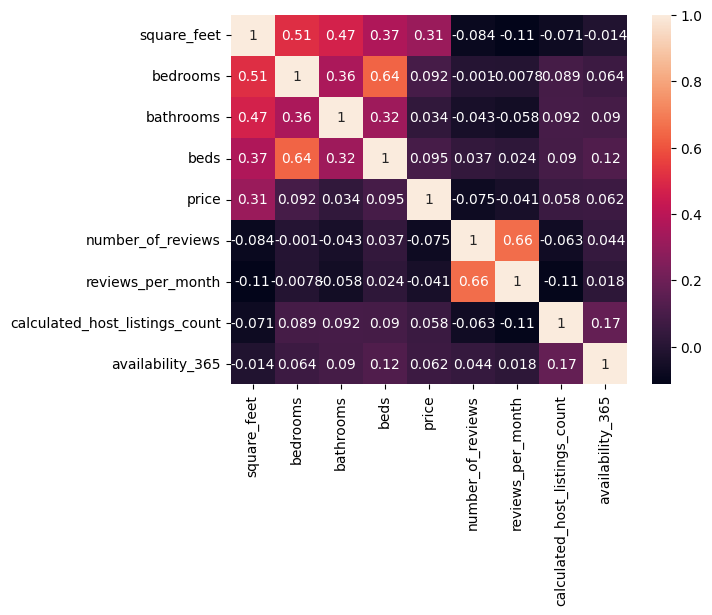

In [70]:
# Ahora analicemos la correlación entre las características de los apartamentos
df_analisis = df_listings[['square_feet', 'bedrooms', 'bathrooms', 'beds', 'price', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

sns.heatmap(df_analisis.corr(), annot=True)

Por ahora vemos las corelaciones que esperaríamos, como el número de habitaciones con el número de camas o el tamaño del apartamento con el número de habitaciones

Una corelación interesante es la del precio con el tamaño del apartamento, algo lógico por otra parte. Seguiremos analizando estos datos con la ubicación y las reseñas.

In [74]:
# Cargamos los datos de las reseñas de los apartamentos

df_reviews = pd.read_csv('../../data/reviews.csv.gz', encoding='utf-8')
print(df_reviews.head())

   listing_id     id        date  reviewer_id reviewer_name  \
0        6369  29428  2010-03-14        84790         Nancy   
1        6369  31018  2010-03-23        84338         David   
2        6369  34694  2010-04-10        98655        Marion   
3        6369  37146  2010-04-21       109871          Kurt   
4        6369  38168  2010-04-26        98901        Dennis   

                                            comments  
0  Simon and Arturo have the ultimate location in...  
1  Myself and Kristy originally planned on stayin...  
2  We had a great time at Arturo and Simon's ! A ...  
3  I very much enjoyed the stay.  \r\nIt's a wond...  
4  Arturo and Simon are polite and friendly hosts...  


Como podemos ver, el dataset de reseñas tiene una columna 'comments' que contiene el texto de la reseña

Usaremos este texto para entender el sentimiento de los comentarios y poder valorar el porcentaje de comentarios positivos por apartamento y analizar la evolución

In [219]:
# Cargamos las librerías necesarias para el análisis de sentimiento
from textblob import TextBlob

# Creamos una función que nos permita calcular el sentimiento de un texto
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Aplicamos la función a la columna 'comments' del dataset de reseñas
df_reviews['sentiment'] = df_reviews['comments'].astype(str).apply(get_sentiment)

# Mostramos los datos
# print(df_reviews.head())

# Calculamos el sentimiento medio por apartamento
df_sentiment = df_reviews.groupby('listing_id').agg({'sentiment':'mean'}).reset_index()
# print(df_sentiment.head())

# Calculamos el porcentaje de comentarios positivos por apartamento
df_sentiment['positive'] = df_sentiment['sentiment'] > 0
df_sentiment['positive'] = df_sentiment['positive'].astype(int)
df_sentiment['positive'] = df_sentiment['positive']*100
print(df_sentiment.head())

# Unimos los datos de sentimiento con los datos de los apartamentos
df_listings = df_listings.merge(df_sentiment, left_on='id', right_on='listing_id', how='left')
print(df_listings.head())

# Finalmente calculamos por ahora el porcentaje de comentarios positivos en el dataset
print(f'\n\nPorcentaje de comentarios positivos en el dataset: {df_sentiment["positive"].mean():.2f}%')

      id  host_id neighbourhood  latitude  longitude        room_type  \
0   6369    13660     Chamartín  40.45628   -3.67763     Private room   
1  21853    83531        Aluche  40.40341   -3.74084     Private room   
2  23001    82175       Legazpi  40.38695   -3.69304  Entire home/apt   
3  24805   101471      Malasaña  40.42202   -3.70395  Entire home/apt   
4  24836   101653      Justicia  40.41995   -3.69764  Entire home/apt   

   square_feet  bedrooms  bathrooms  beds  ... sentiment_x  positive_x  \
0        172.0         1        1.0   0.0  ...    0.359115       100.0   
1         97.0         1        1.0   1.0  ...    0.261937       100.0   
2       1184.0         3        2.0   5.0  ...         NaN         NaN   
3          0.0         0        1.0   1.0  ...    0.550556       100.0   
4          NaN         2        1.5   3.0  ...    0.264408       100.0   

   price_m2 price_bedroom  listing_id_y  sentiment_y  positive_y  listing_id  \
0  0.406977     70.000000        636

Casi el 90% de los comentarios son positivos, por lo que quizá no será una variable muy útil para predecir el precio de los apartamentos

Una limitante de este modelo utilizado es que funciona bien para comentarios en inglés pero no tan bien para otros idiomas. 

Tendríamos que probar otros modelos, como por ejemplo LLM o BERT para mejorar la precisión en español o francés, pero por ahora asumiremos que el análisis de sentimiento es suficiente para el ejercicio.

In [15]:
# Cargamos los datos del calendario por apartamento
df_calendar = pd.read_csv('../../data/calendar.csv.gz', encoding='latin1')
print(df_calendar.head())

   listing_id        date available   price adjusted_price  minimum_nights  \
0        6369  2020-01-11         f  $80.00         $80.00             1.0   
1       96072  2020-01-11         f  $25.00         $25.00             3.0   
2       96072  2020-01-12         f  $25.00         $25.00             3.0   
3       96072  2020-01-13         f  $25.00         $25.00             3.0   
4       96072  2020-01-14         f  $25.00         $25.00             3.0   

   maximum_nights  
0           365.0  
1           365.0  
2           365.0  
3           365.0  
4           365.0  


Por ahora estos datos son útiles para ver la disponibilidad de los apartamentos, pero no nos aportan mucho más. 
Podríamos usarlos para ver la evolución de los precios a lo largo del tiempo, pero no es el objetivo de este análisis

Analizaremos el precio de los apartamentos enteros y su relación con el porcentaje de comentarios positivos (para aquellos con reseñas). Un análisis similar se podría hacer para cada categoría (habitaciones individuales y compartidas)


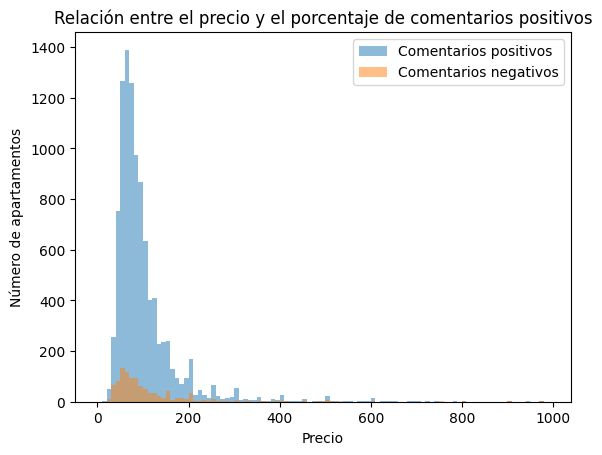

Precio mediano para apartamentos con comentarios positivos: 80.00
Precio mediano para apartamentos con comentarios negativos: 80.00


In [190]:
plt.hist(df_listings[(df_listings['positive'] == 100)&(df_listings['room_type'] == 'Entire home/apt')]['price'], bins=range(0, 1000, 10), alpha=0.5, label='Comentarios positivos')
plt.hist(df_listings[(df_listings['positive'] == 0)&(df_listings['room_type'] == 'Entire home/apt')]['price'], bins=range(0, 1000, 10), alpha=0.5, label='Comentarios negativos')
plt.xlabel('Precio')
plt.ylabel('Número de apartamentos')
plt.legend()
plt.title('Relación entre el precio y el porcentaje de comentarios positivos')
plt.show()

# Calculamos el precio mediano para las dos categorías y apartamento entero
print(f'Precio mediano para apartamentos con comentarios positivos: {df_listings[(df_listings["positive"] == 100)&(df_listings["room_type"] == "Entire home/apt")]["price"].median():.2f}')
print(f'Precio mediano para apartamentos con comentarios negativos: {df_listings[(df_listings["positive"] == 0)&(df_listings["room_type"] == "Entire home/apt")]["price"].median():.2f}')

Vemos que los pisos enteros tienen el mismo precio mediano independientemente del porcentaje de comentarios positivos

Ahora analizaremos el precio de los apartamentos y su relación con su barrio, calculando el precio medio por barrio y su desviación estándar

    neighbourhood  mean_price   std_price
24     Canillejas  495.397727  884.917329
15          Arcos  479.266667  698.398538
126         Zofío  473.673469  559.306989
58         Hellín  428.437500  463.927548
102         Rosas  421.739130  660.604204
..            ...         ...         ...
92       Portazgo   53.040000   88.214248
125  Vista Alegre   52.826087   76.120779
3      Aeropuerto   47.235294   27.659830
9          Aluche   41.151515   48.824209
60        Horcajo   23.500000    9.192388

[127 rows x 3 columns]


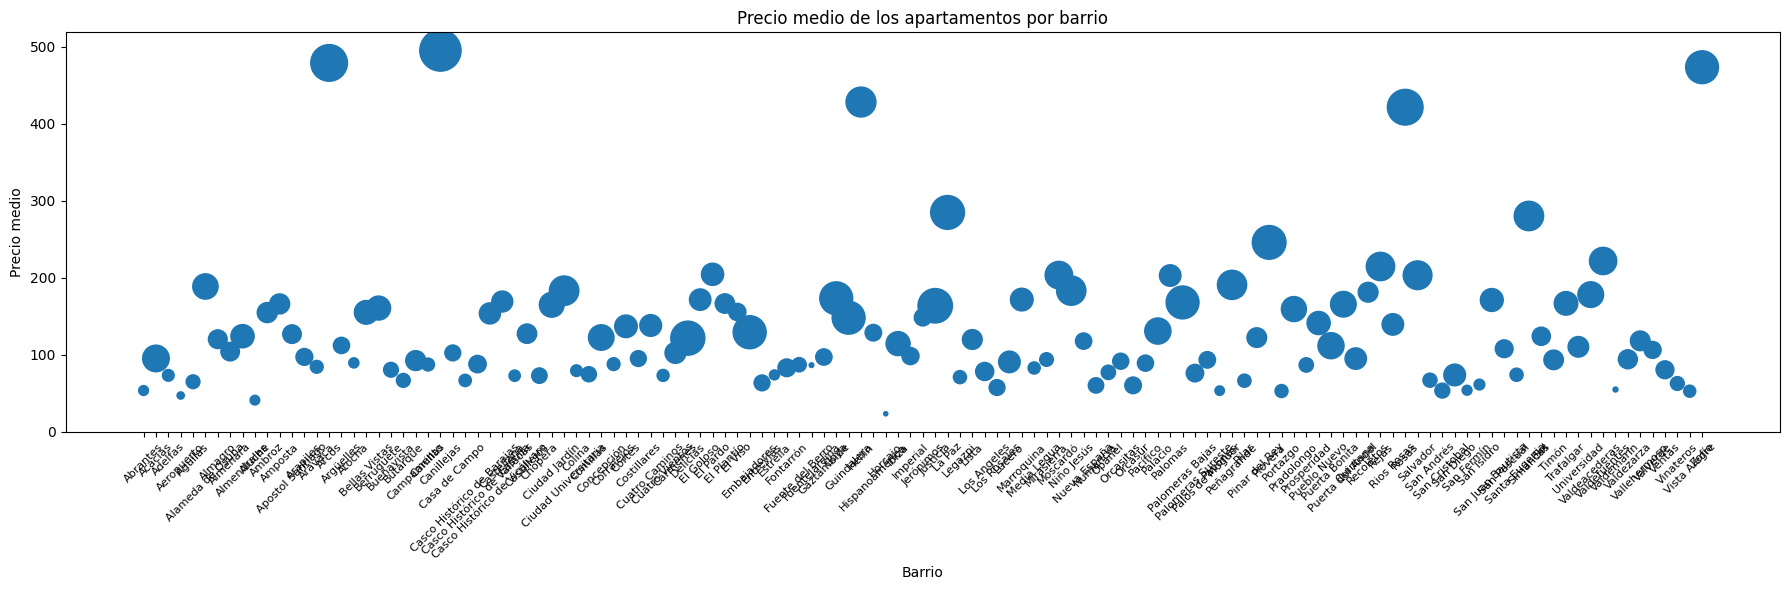

In [197]:
df_neighbourhood = df_listings_lite.groupby('neighbourhood').agg({'price':['mean', 'std']}).reset_index()
df_neighbourhood.columns = ['neighbourhood', 'mean_price', 'std_price']
print(df_neighbourhood.sort_values(by='mean_price', ascending=False))

# Ahora lo representamos gráficamente en burbujas, con el tamaño de la burbuja representando la desviación estándar
plt.figure(figsize=(18, 6))
plt.scatter(df_neighbourhood['neighbourhood'], df_neighbourhood['mean_price'], s=df_neighbourhood['std_price'])
plt.xticks(rotation=45, fontsize=8)
plt.xlabel('Barrio')
plt.ylabel('Precio medio')
plt.title('Precio medio de los apartamentos por barrio')
plt.tight_layout()
plt.show()

Como podemos ver, el barrio de Canillejas es el más caro, seguido de Arcos y Zofío. Por otro lado, Horcajo es el barrio más barato, seguido de Aluche y Aeropuerto.

Para poder visualizar mejor esta distribución de precios para los que no somos de Madrid o no conocemos los barrios, vamos a representar los precios en un mapa de calor. 

Para ello usaremos los datos de los barrios proporcionados en el archivo GeoJSON proporcionado.

<Axes: >

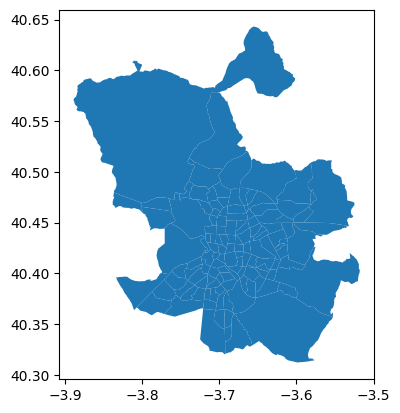

In [187]:
# Cargamos los datos de los barrios de Madrid
import geopandas as gpd

df = gpd.read_file('../../data/neighbourhoods.geojson')
df.plot()

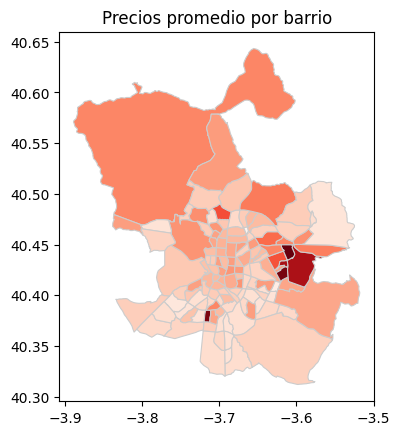

In [198]:
df_heatmap = df[['neighbourhood', 'geometry']].merge(df_neighbourhood[['neighbourhood', 'mean_price']], on='neighbourhood', how='left')

gdf_heatmap = gpd.GeoDataFrame(df_heatmap, geometry='geometry')
gdf_heatmap['mean_price'] = gdf_heatmap['mean_price'].fillna(0)

gdf_heatmap.plot(column='mean_price', cmap='Reds', linewidth=0.8, edgecolor='0.8')
plt.title('Precios promedio por barrio')
plt.show()


Calculamos el área de cada barrio para poder analizar la densidad de apartamentos

                    neighbourhood  count       area_ha    density
113                           Sol   1401     44.511603  31.474939
49                    Embajadores   2811    103.325346  27.205329
116                   Universidad   2091     94.761560  22.065909
39                         Cortes   1024     59.204851  17.295880
64                       Justicia   1207     74.203130  16.266160
..                            ...    ...           ...        ...
28   Casco Histórico de Vicálvaro     51   3283.865226   0.015530
119                    Valdemarín      4    330.242145   0.012112
3                      Aeropuerto     17   2510.801299   0.006771
45                      El Goloso     13   2648.651475   0.004908
46                       El Pardo      3  18755.576117   0.000160

[127 rows x 4 columns]


Barrio con más apartamentos: Embajadores


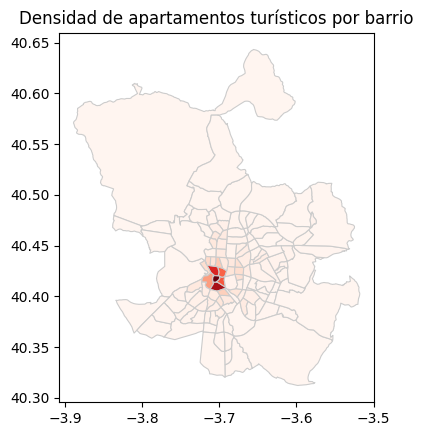

In [223]:

# Para ello reproyectamos los datos de coordenadas a un sistema de referencia de coordenadas adecuado para Madrid (UTM 30N)

gdf_projected = df.to_crs(epsg=32630)
gdf_projected['area_ha'] = gdf_projected['geometry'].area / 10000

# Una vez tenemos el área de cada barrio, calculamos la densidad de apartamentos por barrio
df_density = df_listings_lite.groupby('neighbourhood').agg({'id':'count'}).reset_index()
df_density.columns = ['neighbourhood', 'count']
df_density = df_density.merge(gdf_projected[['neighbourhood', 'area_ha']], on='neighbourhood', how='left')
df_density['density'] = df_density['count'] / df_density['area_ha']

print(df_density.sort_values(by='density', ascending=False))
print('\n\nBarrio con más apartamentos:', df_density.sort_values(by='count', ascending=False).iloc[0]['neighbourhood'])

# Representamos la densidad de apartamentos en un mapa de calor
df_heatmap_density = df[['neighbourhood', 'geometry']].merge(df_density[['neighbourhood', 'density']], on='neighbourhood', how='left')

gdf_heatmap_density = gpd.GeoDataFrame(df_heatmap_density, geometry='geometry')
gdf_heatmap_density['density'] = gdf_heatmap_density['density'].fillna(0)

gdf_heatmap_density.plot(column='density', cmap='Reds', linewidth=0.8, edgecolor='0.8')
plt.title('Densidad de apartamentos turísticos por barrio')
plt.show()


Como podemos ver, los barrios de Sol y Embajadores son los que tienen mayor densidad de apartamentos, siendo este último el que más apartamentos turísticos tiene de toda la ciudad.

Finalmente analizaremos el precio de los apartamentos y su relación con el tamaño del apartamento

In [232]:
# Calculamos el precio por m2 y el precio por habitaciones
df_listings['price_sqfeet'] = df_listings.apply(lambda x: x['price'] / x['square_feet'] if x['square_feet'] > 0 else 0, axis=1)
df_listings['price_bedroom'] = df_listings.apply(lambda x: x['price'] / x['bedrooms'] if x['bedrooms'] > 0 else 0, axis=1)
print(df_listings.head())

      id  host_id neighbourhood  latitude  longitude        room_type  \
0   6369    13660     Chamartín  40.45628   -3.67763     Private room   
1  21853    83531        Aluche  40.40341   -3.74084     Private room   
2  23001    82175       Legazpi  40.38695   -3.69304  Entire home/apt   
3  24805   101471      Malasaña  40.42202   -3.70395  Entire home/apt   
4  24836   101653      Justicia  40.41995   -3.69764  Entire home/apt   

   square_feet  bedrooms  bathrooms  beds  price  minimum_nights  \
0        172.0       1.0        1.0   0.0   70.0               1   
1         97.0       1.0        1.0   1.0   17.0               4   
2       1184.0       3.0        2.0   5.0   50.0              15   
3          0.0       0.0        1.0   1.0   80.0               5   
4          NaN       2.0        1.5   3.0  115.0               3   

   number_of_reviews last_review  reviews_per_month  \
0                 73  2019-12-13               0.61   
1                 33  2018-07-15          

In [249]:
# Calculamos el promedio y stdev del precio por habitación según el número de habitaciones
df_bedrooms = df_listings.groupby('bedrooms').agg({'price_bedroom':['mean', 'std']}).reset_index()
df_bedrooms.columns = ['bedrooms', 'mean_price_bedroom', 'std_price_bedroom']
print('\n\nPrecio por habitación según el número de habitaciones\n')
print(df_bedrooms)

df_bedrooms = df_listings.groupby('bedrooms').agg({'price':['mean', 'std']}).reset_index()
df_bedrooms.columns = ['bedrooms', 'price', 'std_price_bedroom']
print('\n\nPrecio según el número de habitaciones\n')
print(df_bedrooms)



Precio por habitación según el número de habitaciones

   bedrooms  mean_price_bedroom  std_price_bedroom
0       0.0            0.000000           0.000000
1       1.0           59.298429          65.675438
2       2.0           44.246154          18.529985
3       3.0           51.238095          28.910041
4       4.0           41.361111          19.345991
5       5.0           70.000000                NaN


Precio según el número de habitaciones

   bedrooms       price  std_price_bedroom
0       0.0   70.142857          28.142104
1       1.0   59.298429          65.675438
2       2.0   88.492308          37.059970
3       3.0  153.714286          86.730123
4       4.0  165.444444          77.383963
5       5.0  350.000000                NaN


Interesante ver como los apartamentos con menos habitaciones tienen un mayor precio por habitación, siendo una relación inversamente proporcional. Aún así, lógicamente cuantas más habitaciones mayoer es el precio global. Grafiquemos estos datos para verlo mejor.

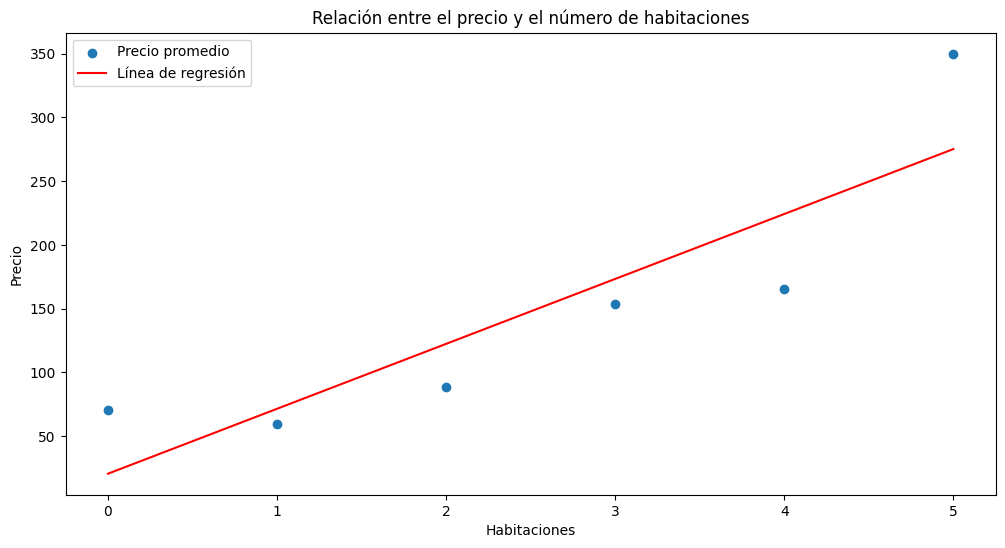

La ecuación de la regresión es: y = 50.94x + 20.50


In [251]:
# Eliminar valores na
df_bedrooms = df_bedrooms.dropna(subset=['bedrooms', 'price'])

# Crear el scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df_bedrooms['bedrooms'], df_bedrooms['price'], label='Precio promedio')

# Calcular línea de regresión
slope, intercept = np.polyfit(df_bedrooms['bedrooms'], df_bedrooms['price'], 1)
regression_line = slope * df_bedrooms['bedrooms'] + intercept

plt.plot(df_bedrooms['bedrooms'], regression_line, color='red', label='Línea de regresión')
plt.xlabel('Habitaciones')
plt.ylabel('Precio')
plt.legend()
plt.title('Relación entre el precio y el número de habitaciones')

# Show plot
plt.show()

# Mostraremos la ecuación de la regresión para poder tener presente la pendiente
print(f'La ecuación de la regresión es: y = {slope:.2f}x + {intercept:.2f}')

A nivel general, por cada habitación extra el precio del apartamento aumenta en 50€

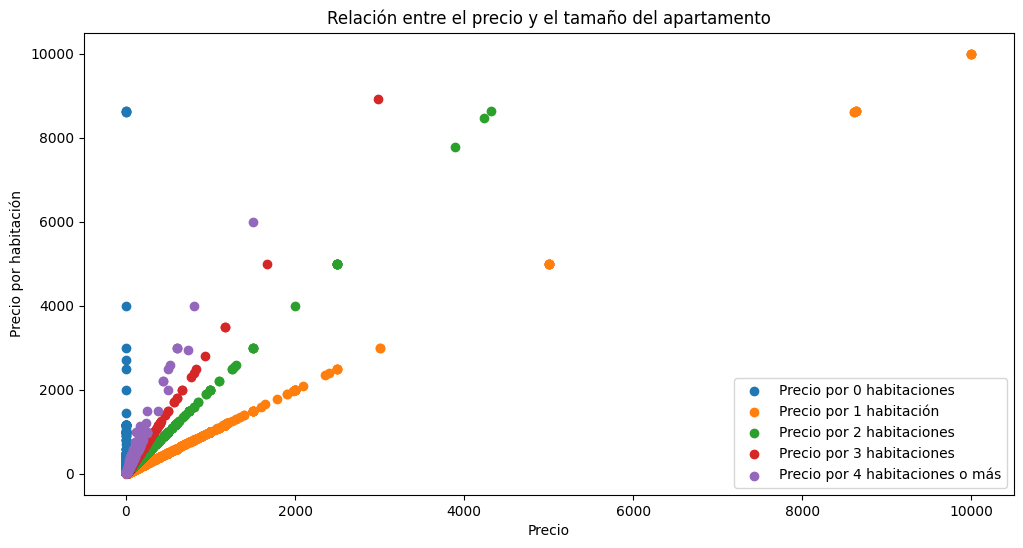

In [222]:
# Primero agruparemos los datos según el número de habitaciones en valor absoluto
df_listings['bedrooms'] = df_listings['bedrooms'].fillna(0)
df_listings['bedrooms'] = df_listings['bedrooms'].astype(int)

plt.figure(figsize=(12, 6))
plt.scatter(df_listings[df_listings.bedrooms == 0].price_bedroom, df_listings[df_listings.bedrooms == 0].price, label='Precio por 0 habitaciones')
plt.scatter(df_listings[df_listings.bedrooms == 1].price_bedroom, df_listings[df_listings.bedrooms == 1].price, label='Precio por 1 habitación')
plt.scatter(df_listings[df_listings.bedrooms == 2].price_bedroom, df_listings[df_listings.bedrooms == 2].price, label='Precio por 2 habitaciones')
plt.scatter(df_listings[df_listings.bedrooms == 3].price_bedroom, df_listings[df_listings.bedrooms == 3].price, label='Precio por 3 habitaciones')
plt.scatter(df_listings[df_listings.bedrooms > 3].price_bedroom, df_listings[df_listings.bedrooms > 3].price, label='Precio por 4 habitaciones o más')
plt.xlabel('Precio')
plt.ylabel('Precio por habitación')
plt.legend()
plt.title('Relación entre el precio y el tamaño del apartamento')
plt.show()



Definitivamente el número de habitaciones es un factor a tener en cuenta para determinar el precio de los aparatmentos (además de la ubicación como vimos anteriormente). 
Además, podemos comprobar que aquellos apartamentos con 1 habitación son los más rentables en términos de precio por habitación.

Analicemos por último el precio según el tamaño del apartamento, dado que en heatmap que calculamos al inicio nos dio una fuerte correlación

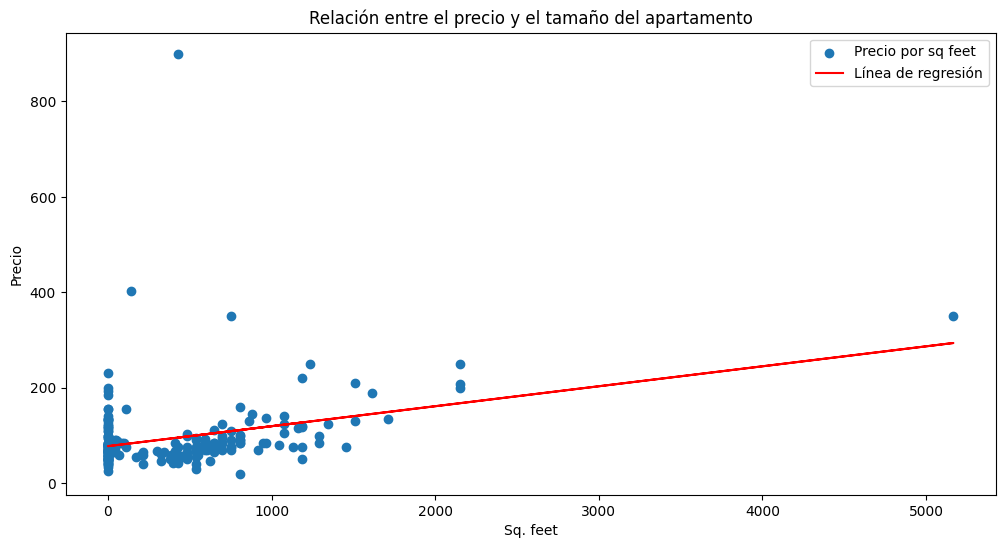

La ecuación de la regresión es: y = 0.04x + 77.77


In [246]:
# Filtramos por apartamentos completos dado que el precio por m2 para habitaciones individuales o compartidas puede ser objeto de un estudio por separado
df_precio = df_listings[(df_listings['room_type'] == 'Entire home/apt')]

df_precio.loc[:,'square_feet'] = pd.to_numeric(df_precio['square_feet'], errors='coerce')
df_precio.loc[:,'price'] = pd.to_numeric(df_precio['price'], errors='coerce')

# Eliminar valores na
df_precio = df_precio.dropna(subset=['square_feet', 'price'])

# Crear el scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df_precio['square_feet'], df_precio['price'], label='Precio por sq feet')

# Calcular línea de regresión
slope, intercept = np.polyfit(df_precio['square_feet'], df_precio['price'], 1)
regression_line = slope * df_precio['square_feet'] + intercept

plt.plot(df_precio['square_feet'], regression_line, color='red', label='Línea de regresión')
plt.xlabel('Sq. feet')
plt.ylabel('Precio')
plt.legend()
plt.title('Relación entre el precio y el tamaño del apartamento')

# Show plot
plt.show()

# Mostraremos la ecuación de la regresión para poder tener presente la pendiente
print(f'La ecuación de la regresión es: y = {slope:.2f}x + {intercept:.2f}')

Estos datos nos muestran que efectivamente el precio depende del tamaño del apartamento aunque no tanto como podríamos esperar en un inicio, aumentando 0.04€ por cadasq feet (o 0.1m2).

Una vez analizados los datos, hemos podido ver que el precio de los apartamentos turísticos en Madrid depende en mayor medida del número de habitaciones y de su ubicación, de manera moderada según el tamaño del apartamento, y no tanto de las reseñas.

Este análisis podríamos haberlo hecho mucho más largo y completo, analizando también la influencia de la ocupación, de las noches mínimas, de su disponibilidad, evolución a lo largo del año o de si se trata de un gran propietario entre otros, 
pero para efectos de este ejercicio lo dejaremos aquí para pasar a la siguiente fase, la de la limpieza de datos, construcción de nuevas variables y modelado.